In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, silhouette_score

In [2]:
# Step 1: Load the data
file_path = 'Online Retail.xlsx'
df = pd.read_excel(file_path)

# Step 2: Basic Data Exploration
print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset Information:")
print(df.info())
print("\nDescriptive Statistics for Numerical Columns:")
print(df.describe())

First 5 rows of the dataset:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null C

In [4]:
# Step 3: Data Cleaning
# Drop rows with missing CustomerID and fill missing Description
df = df.dropna(subset=['CustomerID'])
df['Description'] = df['Description'].fillna('Unknown')

# Remove rows with negative Quantity and UnitPrice, and drop duplicates
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)].drop_duplicates()

# Convert CustomerID to integer and create TotalPrice feature
df['CustomerID'] = df['CustomerID'].astype(int)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Display cleaned data summary
print("Cleaned Dataset Information:")
print(df.info())
print("\nDescriptive Statistics After Cleaning:")
print(df.describe())

C:\Users\milto\AppData\Local\Temp\ipykernel_9312\2458599867.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description'] = df['Description'].fillna('Unknown')


Cleaned Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int32         
 7   Country      392692 non-null  object        
 8   TotalPrice   392692 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(4)
memory usage: 28.5+ MB
None

Descriptive Statistics After Cleaning:
            Quantity                    InvoiceDate      UnitPrice  \
count  392692.000000                         392692  392692.000000   
mean       13.119702  2011-07-10 19:13:

In [5]:
# Step 4: Outlier Analysis
# Identify the top 1% of records for Quantity, UnitPrice, and TotalPrice
q_upper_limit = df['Quantity'].quantile(0.99)
up_upper_limit = df['UnitPrice'].quantile(0.99)
tp_upper_limit = df['TotalPrice'].quantile(0.99)

# Filter out the top 1% values for examination
quantity_outliers = df[df['Quantity'] > q_upper_limit]
unitprice_outliers = df[df['UnitPrice'] > up_upper_limit]
totalprice_outliers = df[df['TotalPrice'] > tp_upper_limit]

# Print a sample of these outliers for inspection
print("Quantity Outliers:")
print(quantity_outliers.head())
print("\nUnit Price Outliers:")
print(unitprice_outliers.head())
print("\nTotal Price Outliers:")
print(totalprice_outliers.head())

Quantity Outliers:
    InvoiceNo StockCode                     Description  Quantity  \
178    536387     79321                   CHILLI LIGHTS       192   
179    536387     22780  LIGHT GARLAND BUTTERFILES PINK       192   
180    536387     22779      WOODEN OWLS LIGHT GARLAND        192   
181    536387     22466   FAIRY TALE COTTAGE NIGHTLIGHT       432   
182    536387     21731   RED TOADSTOOL LED NIGHT LIGHT       432   

            InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
178 2010-12-01 09:58:00       3.82       16029  United Kingdom      733.44  
179 2010-12-01 09:58:00       3.37       16029  United Kingdom      647.04  
180 2010-12-01 09:58:00       3.37       16029  United Kingdom      647.04  
181 2010-12-01 09:58:00       1.45       16029  United Kingdom      626.40  
182 2010-12-01 09:58:00       1.25       16029  United Kingdom      540.00  

Unit Price Outliers:
    InvoiceNo StockCode                         Description  Quantity  \
45     53

In [6]:
# Step 5: Feature Engineering
# Extracting additional features from InvoiceDate
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceDayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['InvoiceHour'] = df['InvoiceDate'].dt.hour

# Step 6: RFM Analysis
# Assuming the latest date in the dataset to be the reference date
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Create Recency, Frequency, and Monetary value per customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency (Number of invoices)
    'TotalPrice': 'sum'  # Monetary Value
}).reset_index().rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'MonetaryValue'
})

print("\nRFM Analysis Sample:")
print(rfm.head())


RFM Analysis Sample:
   CustomerID  Recency  Frequency  MonetaryValue
0       12346      326          1       77183.60
1       12347        2          7        4310.00
2       12348       75          4        1797.24
3       12349       19          1        1757.55
4       12350      310          1         334.40


In [7]:
# Step 7: Exploratory Data Analysis (EDA)
total_revenue = df['TotalPrice'].sum()
average_revenue = df['TotalPrice'].mean()
order_value_df = df.groupby('InvoiceNo')['TotalPrice'].sum()  # Summing TotalPrice per invoice
average_order_value = order_value_df.mean()
unique_customers = df['CustomerID'].nunique()
customer_order_frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()

# Display Summary Statistics
print("Summary Statistics:")
print(f"Total Revenue: {total_revenue}")
print(f"Average Revenue: {average_revenue}")
print(f"Average Order Value: {average_order_value}")
print(f"Number of Unique Customers: {unique_customers}")
print(f"Average Order Frequency per Customer: {customer_order_frequency.mean()}")

Summary Statistics:
Total Revenue: 8887208.894
Average Revenue: 22.6314997351614
Average Order Value: 479.56016047917126
Number of Unique Customers: 4338
Average Order Frequency per Customer: 4.272014753342554


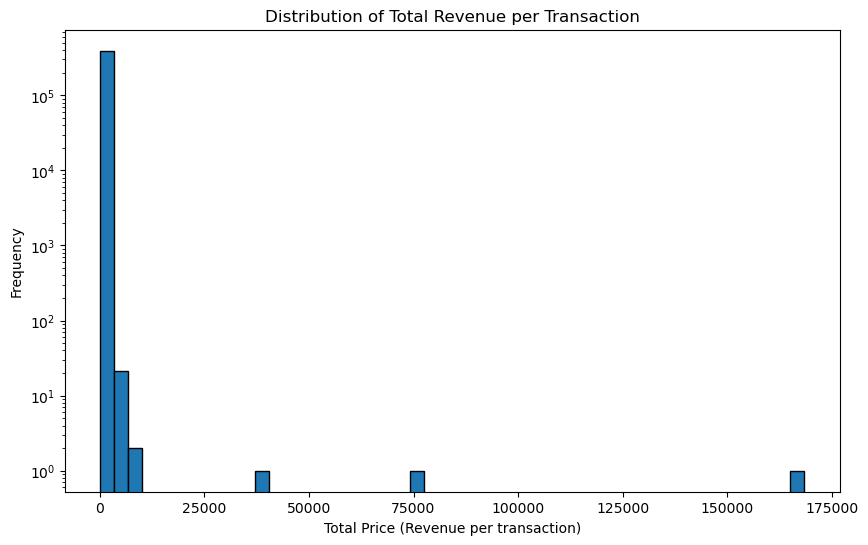

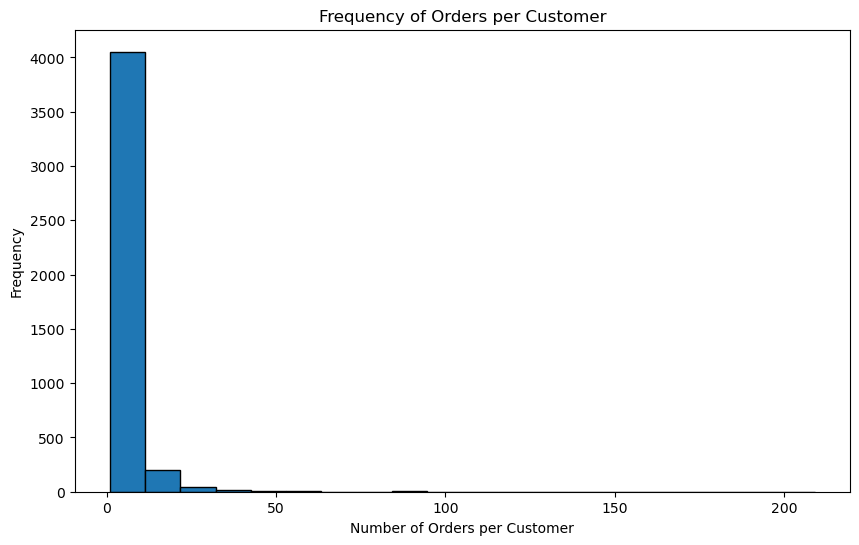

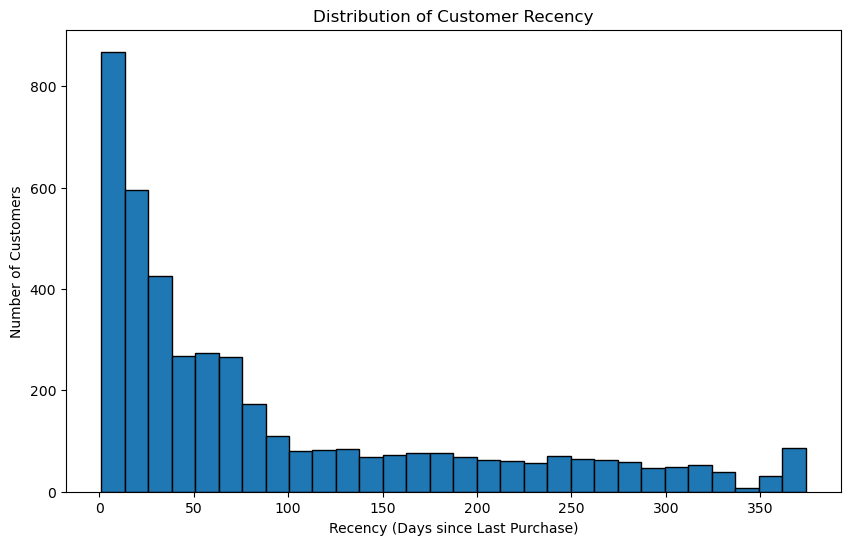

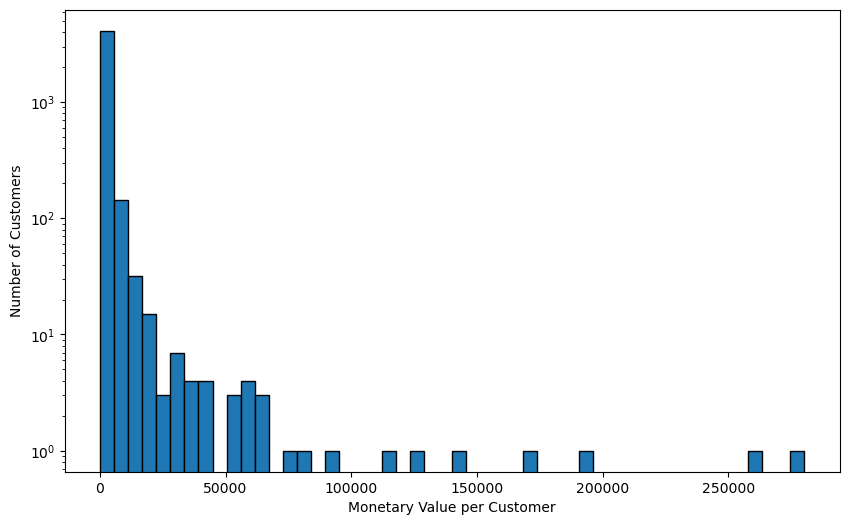

In [8]:
# Step 8: Visualizations
# Visualization of Total Revenue Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['TotalPrice'], bins=50, edgecolor='k')
plt.xlabel('Total Price (Revenue per transaction)')
plt.ylabel('Frequency')
plt.title('Distribution of Total Revenue per Transaction')
plt.yscale('log')  # Log scale to handle skewness
plt.show()

# Visualization of Frequency of Orders per Customer
plt.figure(figsize=(10, 6))
plt.hist(customer_order_frequency, bins=20, edgecolor='k')
plt.xlabel('Number of Orders per Customer')
plt.ylabel('Frequency')
plt.title('Frequency of Orders per Customer')
plt.show()

# Visualization of Recency Distribution
plt.figure(figsize=(10, 6))
plt.hist(rfm['Recency'], bins=30, edgecolor='k')
plt.xlabel('Recency (Days since Last Purchase)')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customer Recency')
plt.show()

# Visualization of Monetary Value Distribution
plt.figure(figsize=(10, 6))
plt.hist(rfm['MonetaryValue'], bins=50, edgecolor='k')
plt.xlabel('Monetary Value per Customer')
plt.ylabel('Number of Customers')
plt.yscale('log')  # Log scale to handle skewness
plt.show()

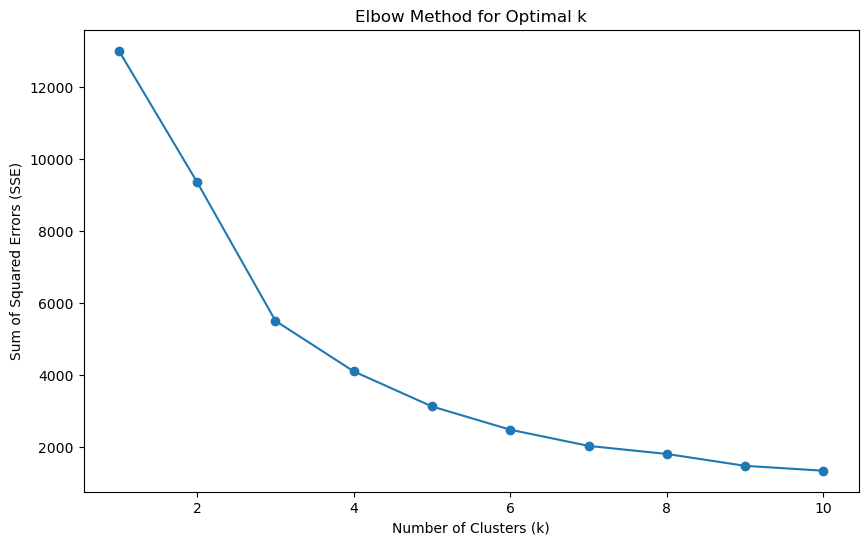

Silhouette Score for k=4: 0.6162275299061803


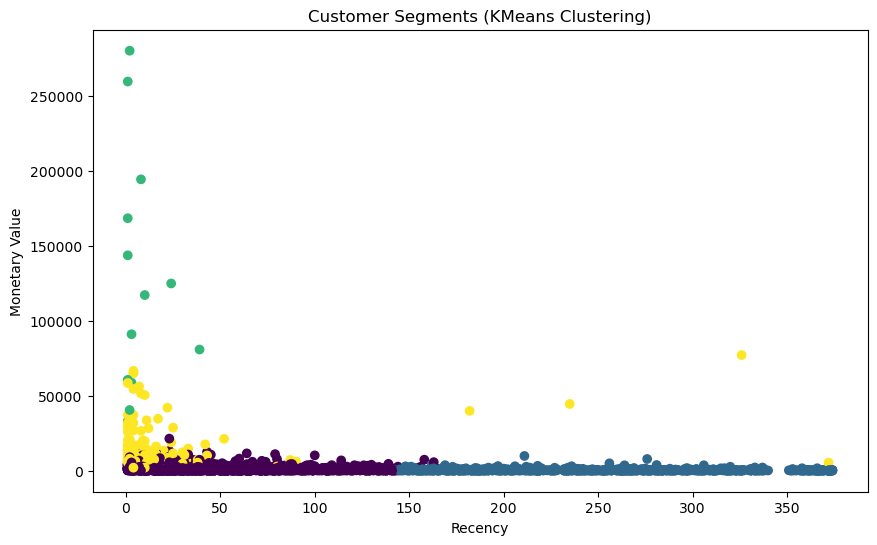

In [9]:

# Step 9: Customer Segmentation
# Data Normalization
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm[['Recency', 'Frequency', 'MonetaryValue']])

# KMeans Clustering
sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    sse.append(kmeans.inertia_)

# Elbow Method for Optimal k
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Choosing k and fitting KMeans
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_normalized)

# Silhouette Score
silhouette_avg = silhouette_score(rfm_normalized, rfm['KMeans_Cluster'])
print(f"Silhouette Score for k={optimal_k}: {silhouette_avg}")

# Visualization of KMeans Clusters
plt.figure(figsize=(10, 6))
plt.scatter(rfm['Recency'], rfm['MonetaryValue'], c=rfm['KMeans_Cluster'], cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Monetary Value')
plt.title('Customer Segments (KMeans Clustering)')
plt.show()

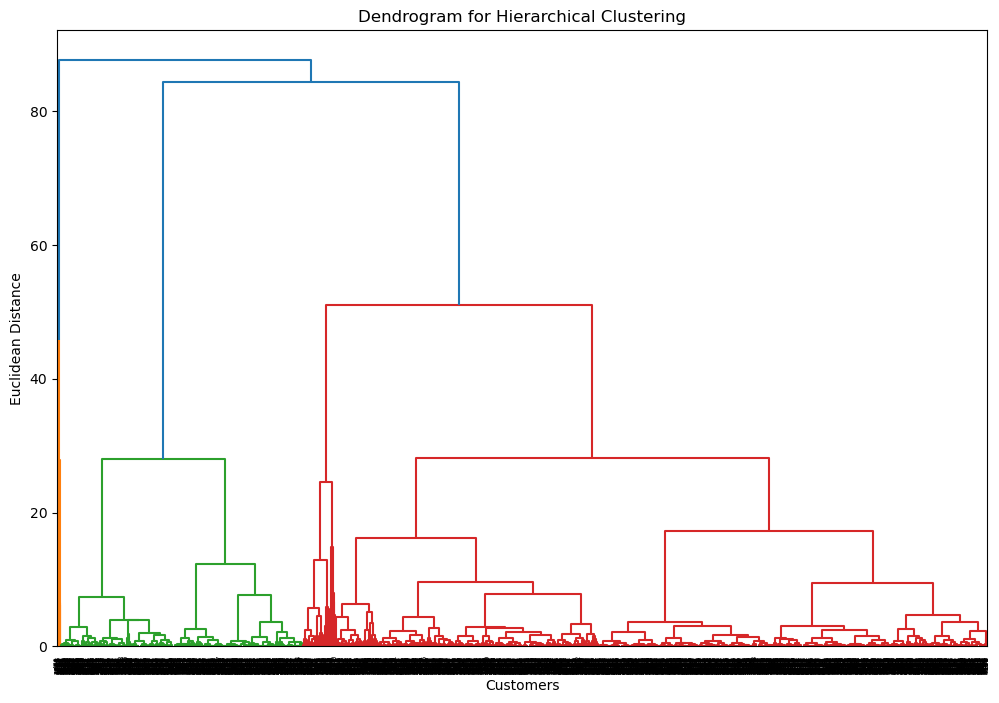

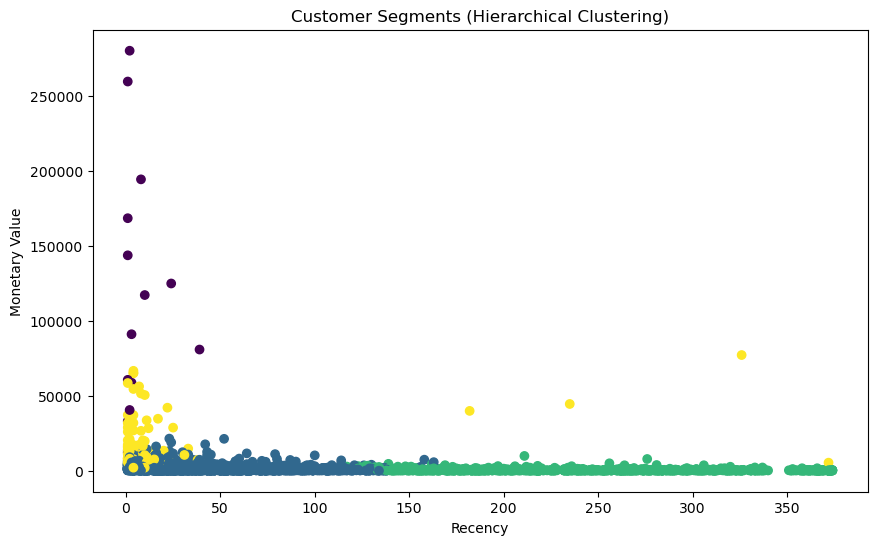

In [11]:
# Step 10: Hierarchical Clustering
linkage_matrix = linkage(rfm_normalized, method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.show()

from sklearn.cluster import AgglomerativeClustering
agg_cluster = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')  # Changed 'affinity' to 'metric'
rfm['Agg_Cluster'] = agg_cluster.fit_predict(rfm_normalized)

# Visualization of Hierarchical Clusters
plt.figure(figsize=(10, 6))
plt.scatter(rfm['Recency'], rfm['MonetaryValue'], c=rfm['Agg_Cluster'], cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Monetary Value')
plt.title('Customer Segments (Hierarchical Clustering)')
plt.show()